<a href="https://colab.research.google.com/github/galib96/quality-prediction-mining/blob/main/quality_prediction_mining_iron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# importing data as dataframe
data_main = pd.read_csv("https://github.com/galib96/quality-prediction-mining/blob/main/DATA/MiningProcess_Flotation_Plant_Database.csv?raw=true",
                        decimal=",")

#check imported data
data_main.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,250.576,295.096,306.4,250.225,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,250.862,295.096,306.4,250.137,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,250.313,295.096,306.4,251.345,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,250.049,295.096,306.4,250.422,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,249.895,295.096,306.4,249.983,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [3]:
# shape of the dataframe
data_main.shape

(737453, 24)

In [4]:
# summary statistics of columns
data_main.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 05 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000,737453.000000
mean,56.294739,14.651716,2869.140569,488.144697,397.578372,9.767639,1.680380,280.151856,277.159965,281.082397,299.447794,299.917814,292.071485,290.754856,520.244823,522.649555,531.352662,420.320973,425.251706,429.941018,421.021231,65.050068,2.326763
std,5.157744,6.807439,1215.203734,91.230534,9.699785,0.387007,0.069249,29.621288,30.149357,28.558268,2.572538,3.636579,30.217804,28.670105,131.014924,128.165050,150.842164,91.794432,84.535822,89.862225,84.891491,1.118645,1.125554
min,42.740000,1.310000,0.002026,241.669000,376.249000,8.753340,1.519820,175.510000,175.156000,176.469000,292.195000,286.295000,189.928000,185.962000,149.218000,210.752000,126.255000,162.201000,166.991000,155.841000,175.349000,62.050000,0.600000
25%,52.670000,8.940000,2076.320000,431.796000,394.264000,9.527360,1.647310,250.281000,250.457000,250.855000,298.262566,298.068000,262.541000,256.302000,416.978000,441.883000,411.325000,356.679000,357.653000,358.497000,356.772000,64.370000,1.440000
50%,56.080000,13.850000,3018.430000,504.393000,399.249000,9.798100,1.697600,299.344000,296.223000,298.696000,299.805000,299.887120,299.477000,299.011000,491.878000,495.956000,494.318000,411.974000,408.773000,424.664575,411.065000,65.210000,2.000000
75%,59.720000,19.600000,3727.730000,553.257000,402.968000,10.038000,1.728330,300.149000,300.690000,300.382000,300.638000,301.791137,303.061000,301.904000,594.114000,595.464000,601.249000,485.549000,484.329000,492.684000,476.465000,65.860000,3.010000
max,65.780000,33.400000,6300.230000,739.538000,418.641000,10.808100,1.853250,373.871000,375.992000,364.346000,305.871000,310.270000,370.910000,371.593000,862.274000,828.919000,886.822000,680.359000,675.644000,698.861000,659.902000,68.010000,5.530000


In [5]:
data_main.isna().sum()

date                            0
% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
dtype: int64

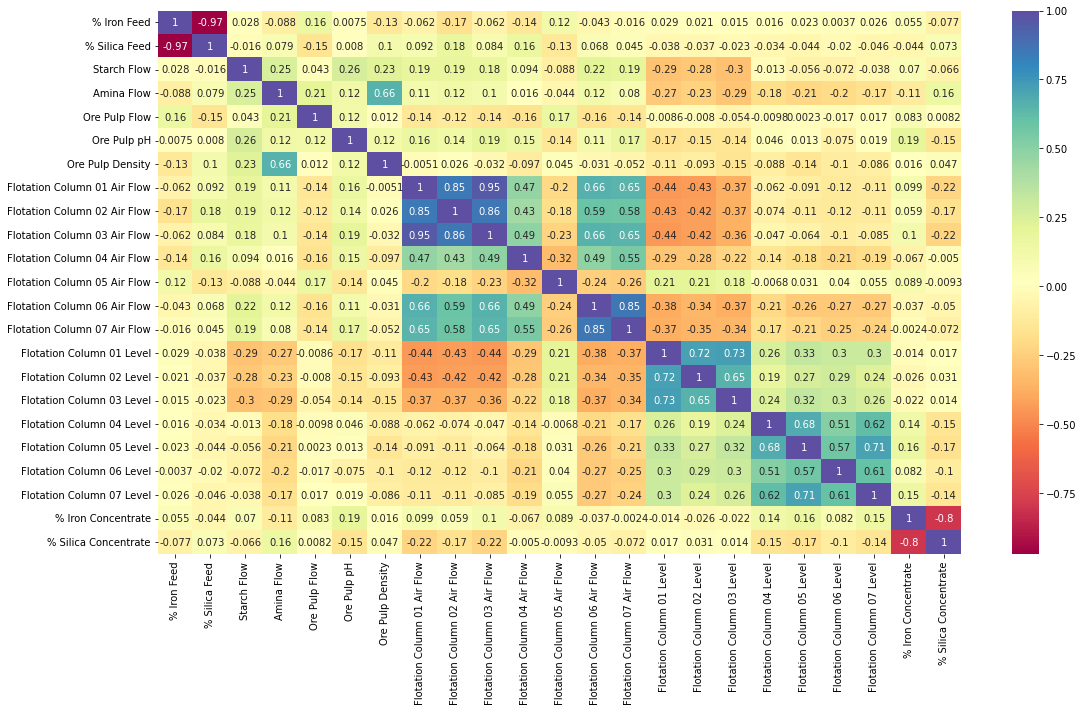

In [14]:
corr = data_main.corr(method='pearson')

plt.figure(figsize = (18,10))
sns.heatmap(corr, cmap="Spectral", annot=True)

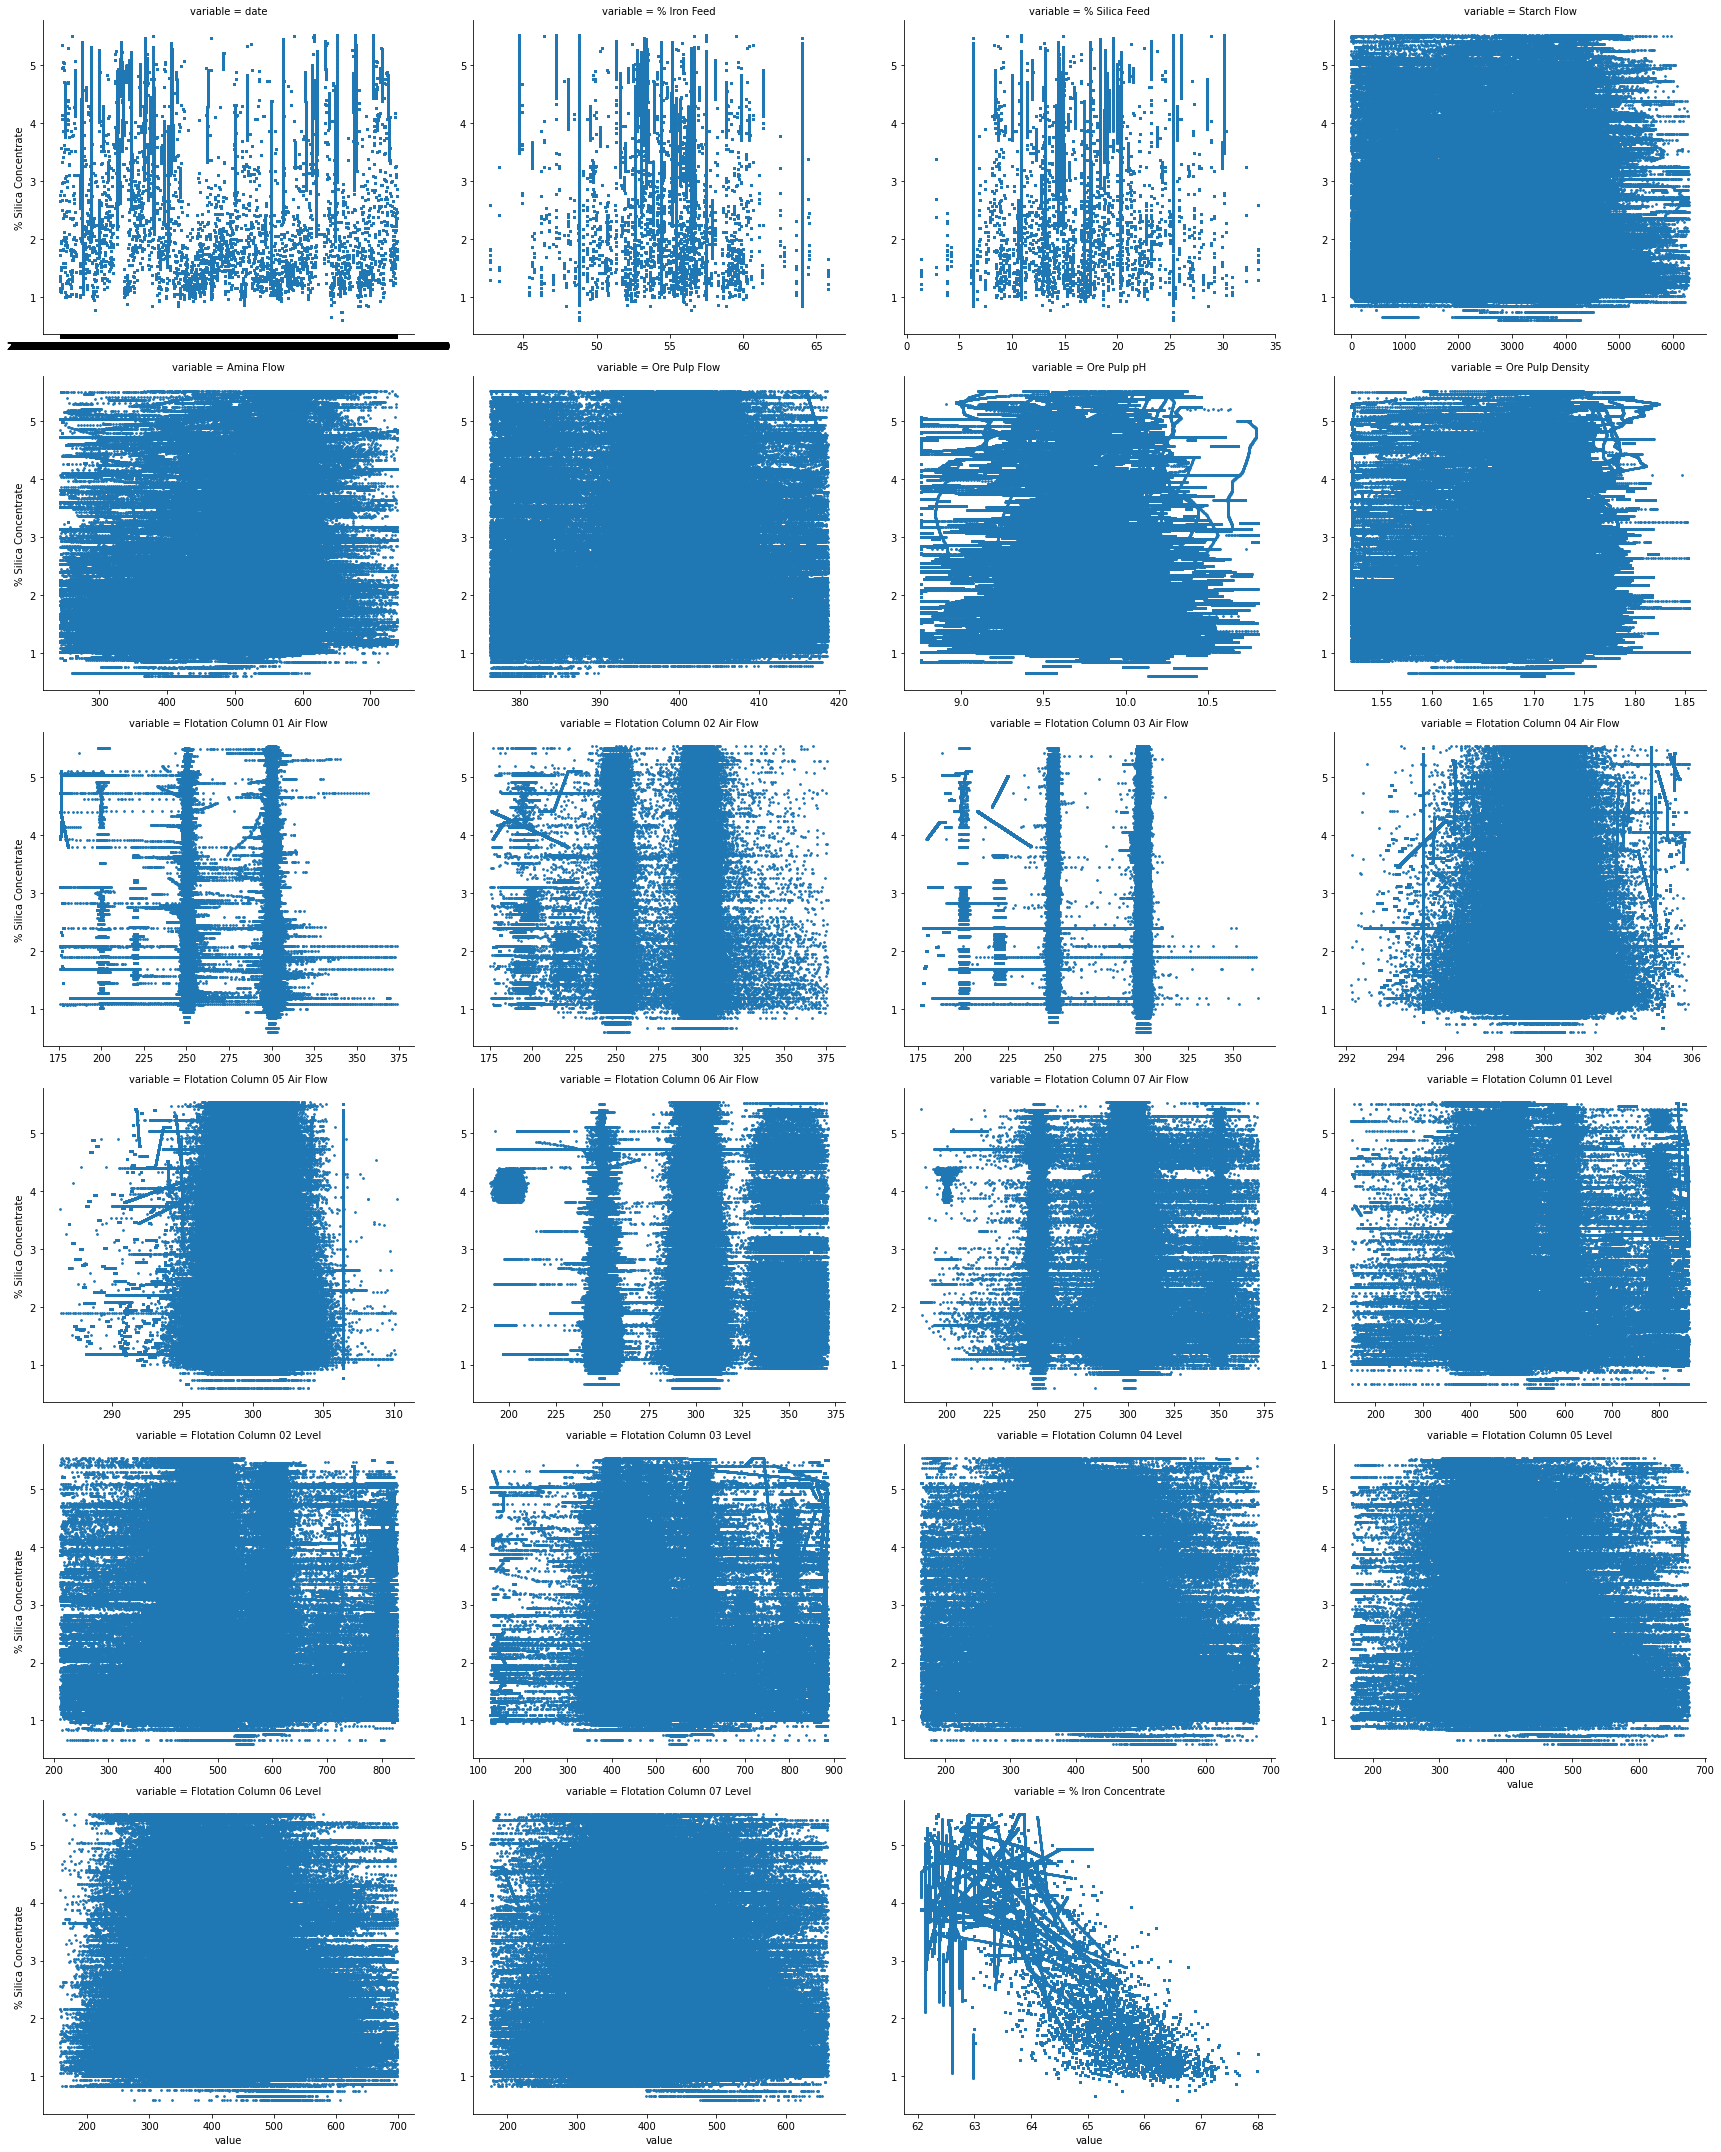

In [27]:
features = list(data_main.columns[:-1])

# scatter plots
temp = pd.melt(data_main, id_vars=['% Silica Concentrate'],value_vars=features)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=4 , height=5.0, 
                     aspect=1.2,sharex=False, sharey=False)
grid.map(plt.scatter, "value",'% Silica Concentrate', s=3)
plt.show()

In [24]:
# sampling from main dataset for trial of different ML techniques 
df_trial = data_main.sample(frac=1.0, replace=False, random_state=11)
df_trial.reset_index(inplace=True, drop=True)
df_trial.shape

(737453, 24)

In [25]:
df_trial.drop(columns=['date', '% Iron Concentrate'], inplace=True)

feature_low_corr = ['Ore Pulp Flow', 'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow',
                    'Flotation Column 01 Level', 'Flotation Column 02 Level', 'Flotation Column 03 Level']

df_trial.drop(columns=feature_low_corr, inplace=True)

df_trial.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,Flotation Column 06 Air Flow,Flotation Column 07 Air Flow,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Silica Concentrate
0,59.48,8.53,2276.560000,421.077,9.12144,1.68510,300.101,293.208,300.059,305.906,295.042,214.308,536.913,596.249,493.373,1.20
1,64.03,6.26,3665.170000,529.751,10.01470,1.72398,249.722,253.156,249.004,299.927,301.126,365.326,355.434,353.795,360.247,1.52
2,56.77,14.37,2318.034625,537.850,9.95123,1.67623,299.897,298.312,302.255,306.297,307.304,334.151,337.059,341.830,334.334,1.53
3,52.11,18.64,1548.097440,603.339,9.53489,1.74787,300.147,302.885,297.289,303.810,299.268,369.750,348.887,197.118,401.435,1.22
4,55.80,15.46,3654.580000,604.334,9.84599,1.72914,301.664,299.857,299.637,306.001,289.929,594.020,573.161,448.907,463.644,3.02


In [26]:
def train_test_splitter(df, test_size):
    X = df.drop(columns='% Silica Concentrate')
    y = df['% Silica Concentrate']
    return train_test_split(X, y, test_size=test_size, random_state=11)

In [29]:
X_train, X_test, y_train, y_test = train_test_splitter(df_trial, test_size=0.1)

In [30]:
stdnorm = StandardScaler()

features = list(X_train.columns)

X_train[features] = stdnorm.fit_transform(X_train[features])

X_test[features] = stdnorm.transform(X_test[features])

X_train = X_train.values
Y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

print("X_train shape", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train shape (663707, 15)
y_train (663707,)
X_test (73746, 15)
y_test (73746,)


In [31]:
# Creating function to get a untrained model from tensorflow
tf.keras.backend.clear_session()
tf.random.set_seed(11)

def get_model():
  model = Sequential([ 
        Dense(256, input_shape=(X_train.shape[1],)),
        ReLU(),
        BatchNormalization(),
        Dropout(0.1),

        Dense(512),
        ReLU(),
        BatchNormalization(),
        Dropout(0.2),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.25),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.25),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.25),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.2),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.2),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.2),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.2),

        # Dense(1024),
        # ReLU(),
        # BatchNormalization(),
        # Dropout(0.15),

        Dense(1024),
        ReLU(),
        BatchNormalization(),
        Dropout(0.15),

        Dense(512),
        ReLU(),
        BatchNormalization(),
        Dropout(0.15),

        Dense(512),
        ReLU(),
        BatchNormalization(),
        Dropout(0.1),

        Dense(512),
        ReLU(),
        BatchNormalization(),
        Dropout(0.1),

        Dense(256),
        ReLU(),
        BatchNormalization(),
        Dropout(0.1),
        
        Dense(1, activation='relu')
    ])
  
  model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=0.001,decay=5e-4),
        metrics=['mean_squared_error']
    )
  
  return model

get_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

In [32]:
class CustomStopper(tf.keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             patience=10, verbose=0, restore_best_weights=True, mode='min', start_epoch = 35): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

lr_call = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min'
    )

cb = CustomStopper()
model = get_model()

history = model.fit(
    X_train, y_train,
    batch_size = 4096,
    validation_split = 0.25,
    epochs=50,
    callbacks=[cb, lr_call]
)

Epoch 1/50
122/122 [==============================] - 10s 63ms/step - loss: 1.3988 - mean_squared_error: 1.3988 - val_loss: 1.1706 - val_mean_squared_error: 1.1706
Epoch 2/50
122/122 [==============================] - 7s 59ms/step - loss: 0.8740 - mean_squared_error: 0.8740 - val_loss: 1.0039 - val_mean_squared_error: 1.0039
Epoch 3/50
122/122 [==============================] - 7s 59ms/step - loss: 0.7553 - mean_squared_error: 0.7553 - val_loss: 0.7359 - val_mean_squared_error: 0.7359
Epoch 4/50
122/122 [==============================] - 7s 59ms/step - loss: 0.6876 - mean_squared_error: 0.6876 - val_loss: 0.5946 - val_mean_squared_error: 0.5946
Epoch 5/50
122/122 [==============================] - 7s 59ms/step - loss: 0.6337 - mean_squared_error: 0.6337 - val_loss: 0.5372 - val_mean_squared_error: 0.5372
Epoch 6/50
122/122 [==============================] - 7s 59ms/step - loss: 0.5916 - mean_squared_error: 0.5916 - val_loss: 0.4864 - val_mean_squared_error: 0.4864
Epoch 7/50
122/122 [=

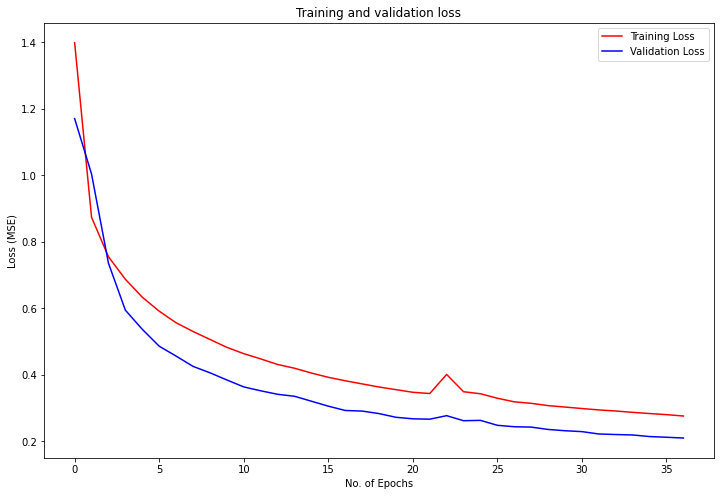

In [33]:
# result of the model training

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

#plt.savefig('/content'+'/ANN Training and Validation Loss - '+'LH Borderline 1.png',dpi=300) ##########

plt.show()

In [34]:
y_pred = model.predict(X_test)
print("mean squared error in test set: ", mean_squared_error(y_test, y_pred))
print("mean absolute error in test set: ", mean_absolute_error(y_test, y_pred))

mean squared error in test set:  0.20759641768206707
mean absolute error in test set:  0.29515791631510424
